In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

In [3]:
from datafold.appfold import EDMD, EDMDControl
from datafold.dynfold import DMDControl, DMDFull
from datafold.dynfold.transform import TSCIdentity, TSCRadialBasis
from datafold.pcfold import (
    InitialCondition,
    InverseMultiquadricKernel,
    PCManifold,
    TSCDataFrame,
)

## Inverted pendulum Physics

In [4]:
from datafold.utils.kmpc import InvertedPendulum

## Data generation

In [5]:
# Data generation parameters
sim_time_step = 0.01  # s
sim_num_steps = 1000  # -
training_size = 20  # -

Different options exist about stacking the trajectories. We start with stacking them into one very long trajectory. (Also to consider reusing the final states, currently resetting to 0).

In [6]:
invertedPendulum = InvertedPendulum()

X = np.zeros((4, training_size * sim_num_steps))
Y = np.zeros((4, training_size * sim_num_steps))
U = np.zeros((1, training_size * sim_num_steps))
Xlist, Ulist = [], []
xycols = ["x", "xdot", "theta", "thetadot"]
np.random.seed(42)
for i in range(training_size):
    control_amplitude = 0.1 + 0.9 * np.random.random()
    control_frequency = np.pi + 2 * np.pi * np.random.random()
    control_phase = 2 * np.pi * np.random.random()
    control_func = lambda t, y: control_amplitude * np.sin(
        control_frequency * t + control_phase
    )
    invertedPendulum.reset()
    traj = invertedPendulum.trajectory(sim_time_step, sim_num_steps, control_func)
    assert (
        invertedPendulum.sol.success
    ), f"Divergent solution for amplitude={control_amplitude}, frequency={control_frequency}"
    t = invertedPendulum.sol.t
    dfx = pd.DataFrame(data=traj.T, index=t, columns=xycols)
    dfx["u"] = 0.0
    Xlist.append(dfx)
    control_input = control_func(t, traj)
    dfu = pd.DataFrame(data=control_input, index=t, columns=("u",))
    for col in xycols:
        dfu[col] = 0.0
    dfu = dfu[xycols + ["u"]]
    Ulist.append(dfu)

    X[:, i * sim_num_steps : (i + 1) * sim_num_steps] = traj[:, :-1]
    Y[:, i * sim_num_steps : (i + 1) * sim_num_steps] = traj[:, 1:]
    U[:, i * sim_num_steps : (i + 1) * sim_num_steps] = control_func(
        invertedPendulum.sol.t[:-1], traj[:, :-1]
    )

XU = TSCDataFrame.from_frame_list(Xlist + Ulist)

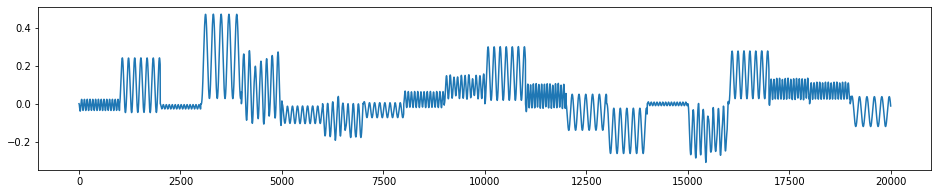

In [7]:
plt.figure(figsize=(16, 3))
plt.plot(X[0].ravel())

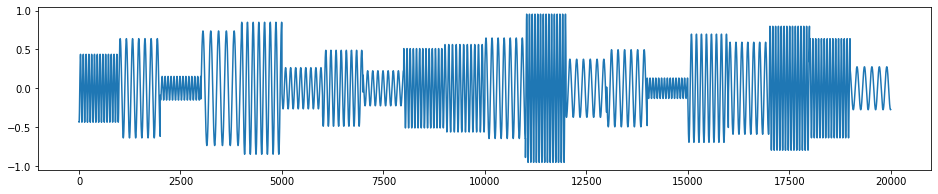

In [8]:
plt.figure(figsize=(16, 3))
plt.plot(U[0].ravel())

In [9]:
X_tsc = TSCDataFrame.from_frame_list(Xlist)[["x", "xdot", "theta", "thetadot"]]
X_tsc["u"] = TSCDataFrame.from_frame_list(Ulist)[["u"]]
X_tsc

feature          x      xdot     theta  thetadot         u
ID time                                                   
0  0.00   0.000000  0.000000  3.141593  0.000000 -0.434292
   0.01  -0.000143 -0.028343  3.141110 -0.095568 -0.436980
   0.02  -0.000562 -0.055111  3.139699 -0.185484 -0.436041
   0.03  -0.001239 -0.080158  3.137421 -0.268933 -0.431481
   0.04  -0.002158 -0.103345  3.134346 -0.345142 -0.423339
...            ...       ...       ...       ...       ...
19 9.96  -0.004673 -0.238609  3.215131 -0.248442 -0.276201
   9.97  -0.007081 -0.242790  3.212441 -0.288352 -0.275695
   9.98  -0.009529 -0.246686  3.209361 -0.326279 -0.274865
   9.99  -0.012015 -0.250292  3.205911 -0.362074 -0.273712
   10.00 -0.014535 -0.253606  3.202116 -0.395593 -0.272238

[20020 rows x 5 columns]

## DMD only

In [10]:
dmdc = DMDControl(
    state_columns=["x", "xdot", "theta", "thetadot"], control_columns=["u"]
)

In [11]:
dmdc.fit(X_tsc)

DMDControl(control_columns=['u'],
           state_columns=['x', 'xdot', 'theta', 'thetadot'])

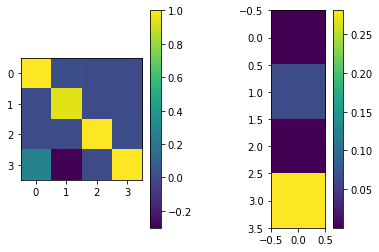

In [12]:
dmdc = DMDControl(
    state_columns=["x", "xdot", "theta", "thetadot"], control_columns=["u"]
)
dmdc.fit(X_tsc, store_system_matrix=True)
plt.subplot(121)
plt.imshow(dmdc.sys_matrix_)
plt.colorbar()
plt.subplot(122)
plt.imshow(dmdc.control_matrix_)
plt.colorbar()

In [13]:
prediction = dmdc.predict(
    np.atleast_2d(np.array([0, 0, np.pi, 0])),
    control_input=np.atleast_2d(control_input).T,
    time_values=t,
)

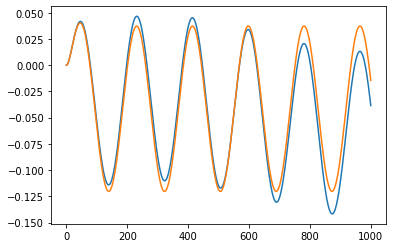

In [14]:
plt.plot(prediction["x"].values)
plt.plot(dfx["x"].values)

## EDMD Predictor

In [15]:
state_cols = ["x", "xdot", "theta", "thetadot"]
control_cols = ["u"]
ic = InitialCondition.from_array(
    np.array([0, 0, np.pi, 0]), columns=["x", "xdot", "theta", "thetadot"]
)

### Using Identity dictionary

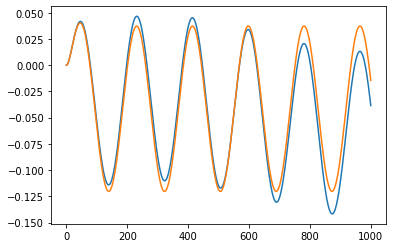

In [16]:
edmdid = EDMDControl(dict_steps=[("id", TSCIdentity()),], include_id_state=False).fit(
    X_tsc,
    split_by="name",
    state=state_cols,
    control=control_cols,
)
idprediction = edmdid.predict(
    ic, control_input=np.atleast_2d(control_input).T, time_values=t
)
plt.plot(idprediction["x"].values)
plt.plot(dfx["x"].values)

### Using dictinoary as per thesis
100 randomly selected RBF centers from a inverse quadratic kernel

In [17]:
num_rbfs = 100
seed = 42
eps = 1


def find_unique_center_ids(num_centers, seed=42, last_choice=None):
    # needed to deal with a bug in the TSCDataFrame code
    assert num_centers < sim_num_steps
    rng = np.random.default_rng(seed)
    center_ids = (
        last_choice
        if last_choice is not None
        else rng.choice(
            range(0, sim_num_steps * training_size), size=num_centers, replace=False
        )
    )
    uniques = np.unique(center_ids % sim_num_steps)
    if len(uniques) == num_centers:
        return center_ids
    else:
        new_choice = np.hstack(
            [
                uniques,
                rng.choice(
                    range(0, sim_num_steps * training_size),
                    size=num_centers - len(uniques),
                    replace=False,
                ),
            ]
        )
        return find_unique_center_ids(num_centers, seed + 1, new_choice)


from datafold.utils.kmpc import InverseQuadraticKernel

rbf = TSCRadialBasis(
    kernel=InverseQuadraticKernel(epsilon=eps), center_type="fit_params"
)
center_ids = sorted(find_unique_center_ids(num_rbfs, seed=seed))
centers = X_tsc.iloc[center_ids].values

d:\documents\tum\hiwi\kmpc\datafold\datafold\dynfold\dmd.py:2078: UserWarning: Shift matrix (shape=(105, 105)) has not full rank (=103), falling back to least squares solution. The sum of residuals is: 0.0
  warnings.warn(


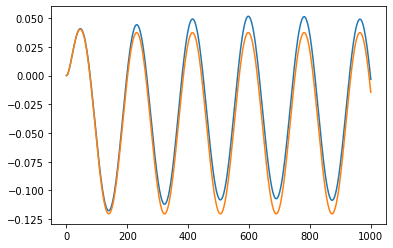

In [18]:
edmdrbf = EDMDControl(dict_steps=[("rbf", rbf),], include_id_state=True).fit(
    X_tsc,
    split_by="name",
    state=state_cols,
    control=control_cols,
    rbf__centers=centers[:, :-1],
)
rbfprediction = edmdrbf.predict(
    ic, control_input=np.atleast_2d(control_input).T, time_values=t
)
plt.plot(rbfprediction["x"].values)
plt.plot(dfx["x"].values)

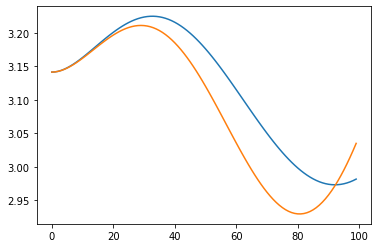

In [19]:
plt.plot(rbfprediction["theta"].values[:100])
plt.plot(dfx["theta"].values[:100])

## Model Predictive Control

In [20]:
from datafold.appfold import KoopmanMPC

In [21]:
horizon = 100

kmpc = KoopmanMPC(
    edmdrbf,
    horizon,
    np.array([[1, -1]]),
    np.array([[5, -5]]),
    ["x"],
    cost_running=np.array([100]),
    cost_terminal=1,
    cost_input=1,
)

In [22]:
ukmpc = kmpc.generate_control_signal(
    rbfprediction.initial_states(), dfx.iloc[: horizon + 1, [0]]
)

In [23]:
kmpcpred = edmdrbf.predict(rbfprediction.initial_states(), control_input=ukmpc)
invertedPendulum.reset()
kmpcfunc = lambda t, y: np.interp(t, rbfprediction.time_values()[:horizon], ukmpc)
kmpctraj = invertedPendulum.trajectory(sim_time_step, horizon, kmpcfunc)
kmpctraj = pd.DataFrame(data=kmpctraj.T, columns=state_cols)

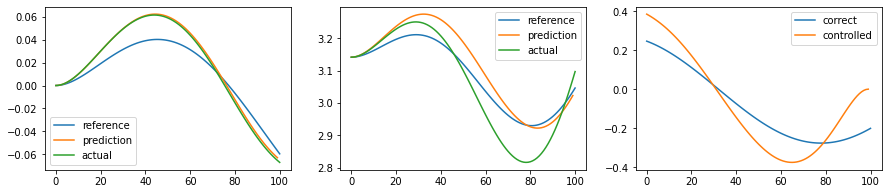

In [24]:
plt.figure(figsize=(15, 3))
plt.subplot(131)
plt.plot(dfx["x"].values[: horizon + 1], label="reference")
plt.plot(kmpcpred["x"].values, label="prediction")
plt.plot(kmpctraj["x"].values, label="actual")
plt.legend()
plt.subplot(132)
plt.plot(dfx["theta"].values[: horizon + 1], label="reference")
plt.plot(kmpcpred["theta"].values, label="prediction")
plt.plot(kmpctraj["theta"].values, label="actual")
plt.legend()
plt.subplot(133)
plt.plot(dfu["u"].values[: horizon + 1], label="correct")
plt.plot(ukmpc, label="controlled")
plt.legend()